In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import cartopy
import math

Caricamento dei file pickle

In [2]:
# Caricamento di models e models_atmos
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)
#Caricamento dei file pickle di modelli_tos
with open('modelli_tos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0_pca = pickle.load(f)
    list_cluster1_pca = pickle.load(f)
    list_cluster2_pca = pickle.load(f)
    list_cluster3_pca = pickle.load(f)
    list_cluster4_pca = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    cluster_0_pdf = pickle.load(f)
    cluster_1_pdf = pickle.load(f)
    cluster_2_pdf = pickle.load(f)
    cluster_3_pdf = pickle.load(f)
    cluster_4_pdf = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    cluster_0_mean_pdf = pickle.load(f)
    cluster_1_mean_pdf = pickle.load(f)
    cluster_2_mean_pdf = pickle.load(f)
    cluster_3_mean_pdf = pickle.load(f)
    cluster_4_mean_pdf = pickle.load(f)

In [3]:
list_cluster0 = list_cluster0_pca
list_cluster1 = list_cluster1_pca
list_cluster2 = list_cluster2_pca
list_cluster3 = list_cluster3_pca
list_cluster4 = list_cluster4_pca

In [4]:
#Gulf stream box della climatologia per tutti i modelli
for name in models:
    #Seleziono il box Nord Atlantico
    na_box = models[name]['North Atlantic box']
    #dataset nel box gulf stream
    models[name]['GS box'] = models[name]['North Atlantic box'].sel(time=slice("1982-01","2014-12"),lon=slice(282,310),lat=slice(29,50))
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli
        model_na_seas_mean = compute_mean_resample_mar(na_box["tos"],"1982","2014",i)
        if (i+1) == 4 : #DJF
            models[name]['tos North Atlantic seasonal mean DJF'] = model_na_seas_mean
    #seleziono un sottobox in cui vado a cercare la corrente del Golfo --> seas mean DJF nel GS box
    models[name]['GS box seas mean DJF'] = models[name]['tos North Atlantic seasonal mean DJF'].sel(lon=slice(282,310), lat=slice(29,50)) #box Gulf Stream

In [5]:
#Gulf stream box della climatologia per ESA-CCI
dict_esa_gs = {}
dict_esa_gs['GS box'] = dataset_ESA_na_celsius.sel(time=slice("1982-01","2014-12"),lon=slice(282,310),lat=slice(29,50)) #Creo per ogni stagione il box GS
for i in range(4): #ciclo su tutte le stagioni MAM, JJA, SON, DJF
    if (i+1) == 4: #DJF
        dict_esa_gs['GS box seas mean DJF'] = esa_na_seas_mean_tos[i+1].sel(lon=slice(282,310), lat=slice(29,50))

Posizione della corrente del Golfo

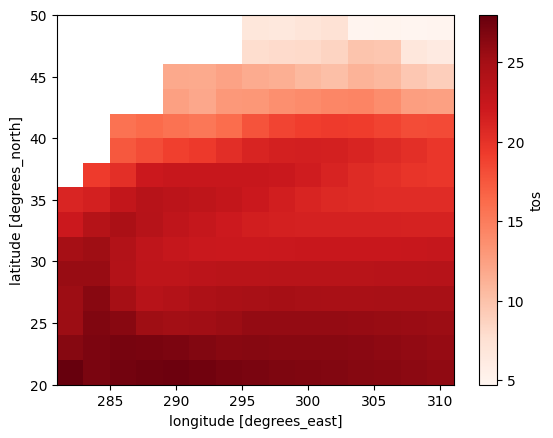

In [6]:
models['ACCESS-CM2']['tos North Atlantic seasonal mean DJF'].sel(lon=slice(282,310), lat=slice(20,50)).plot(cmap = 'Reds')

Calcolo il valore medio di SST per ogni cluster

In [7]:
n_clusters = 5 #number clusters
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3,list_cluster4]
mean_cluster = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)))# (5,len(lat),len(lon)) 
for i in range(len(list_clusters)): #ciclo su tutte le 5 liste, cioè su tutti e 5 i cluster
    sum_bias = 0
    for j in range(len(list_clusters[i])): #ciclo sui singoli modelli della lista i-esima
        model_name = list_clusters[i][j] #modello j-esimo della lista i-esima
        sum_bias = sum_bias + models[model_name]['GS box seas mean DJF']
    mean_cluster[i,:,:] = (sum_bias / len(list_clusters[i])) #media

Calcolo gradiente e determino il massimo per ogni modello, poi calcolo la media dei massimi per ogni cluster

In [8]:
n_clusters = 5 #number clusters
l = 0 #inizializzo indice per il gradiente di tutti i modelli, che mi serve per la gs della multi model mean
gradient_all_models = np.zeros((len(models),len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lat),len(models[list_cluster0[0]]['GS box']['tos'].lon))) #è il gradiente di tutti i modelli, mi serve per calcolare la GS della multi model mean
#Valore medio del gradiente dei modelli dei 5 cluster
mean_gradient = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lat),len(models[list_cluster0[0]]['GS box']['tos'].lon)))# (5,time,len(lat),len(lon))    
#Array con 1, 0 dove gli 1 indicano la latitudine in cui si ha il gradiente massimo medio per ogni cluster
array_max_mean = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lon))) #di dimesnioni 5xtimexlon
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3,list_cluster4]
for n in range(len(list_clusters)): #ciclo su tutte le 5 liste, cioè su tutti e 5 i cluster
    #gradiente sulla latitudine per ogni modello di ogni cluster
    gradient = np.zeros((len(list_clusters[n]),len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lat),len(models[list_cluster0[0]]['GS box']['tos'].lon)))
    #valore massimo per ogni gradient
    index_max_value = np.zeros((len(list_clusters[n]),len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lon)))
    sum_bias = 0 #Inizializzo sum_bias per il calcolo del gradiente medio
    sum_max = 0 #Iniziallizzo sum_max per il calcolo della media del gradiente massimo
    for i in range(len(list_clusters[n])): #ciclo sui singoli modelli della lista i-esima
        for t in range(len(models[list_cluster0[0]]['GS box']['tos'].time)):
            #Ricerca del valore massimo sulla latitudine, a longitudine fissata
            for j in range(len(models[list_cluster0[0]]['GS box']['tos'].lon)): #ciclo sulle longitudini
                gradient[i,t,:,j] = np.gradient(models[list_clusters[n][i]]['GS box']['tos'][t,:,j]) #derivata lungo l'array (i,tutte le lat,lon=j), che ha valori fissati di modello scelto e longitudine --> differenza tra due latitudini vicine, a parità di longitudine
                index_max_value[i,t,j] = np.nanargmax(abs(gradient[i,t,:,j])) #determino l'indice del valore massimo di gradient, non considero i nan come possibili valori massimi
        gradient_all_models[l,:,:,:] = gradient[i,:,:,:]
        l = l + 1 #aggiorno indice per il gradiente di tutti i modelli
        sum_bias = sum_bias + gradient[i,:,:,:] #faccio la somma degli elementi dell'array gradiente a fissata longitudine e modello
        sum_max = sum_max + index_max_value[i,:,:]
    array_max_mean[n,:,:] = (sum_max / len(list_clusters[n])) #media del valore massimo del gradiente
    mean_gradient[n,:,:,:] = (sum_bias / len(list_clusters[n])) #media del gradiente

In [9]:
#calcolo l'indice del valore massimo di gradient_all_models, per ogni modello
index_max_value_all_models = np.zeros((len(models),len(models[list_cluster0[0]]['GS box']['tos'].time),len(models[list_cluster0[0]]['GS box']['tos'].lon)))
sum_max_all_models = 0
for i in range(len(models)): #il massimo lo trovo per ogni modello
    for t in range(len(models[list_cluster0[0]]['GS box']['tos'].time)):
        for j in range(len(models[list_cluster0[0]]['GS box']['tos'].lon)): #ciclo sulle longitudini
            index_max_value_all_models[i,t,j] = np.nanargmax(abs(gradient_all_models[i,t,:,j]))
    sum_max_all_models = sum_max_all_models + index_max_value_all_models[i,:,:]
array_max_mean_all_models = sum_max_all_models / len(models) #media dei valori massimi del gradiente per ogni modello

Stesso procedimento per ESA-CCI --> calcolo la posizione del massimo del gradiente

In [10]:
#Valore medio del gradiente di ESA-CCI
mean_gradient_esa = np.zeros((len(dict_esa_gs['GS box'].time),len(dict_esa_gs['GS box'].lat),len(dict_esa_gs['GS box'].lon)))# (time,len(lat),len(lon))
#gradiente sulla latitudine per ESA-CCI
gradient_esa = np.zeros((len(dict_esa_gs['GS box'].time),len(dict_esa_gs['GS box'].lat),len(dict_esa_gs['GS box'].lon)))
#valore massimo per ogni gradient per ESA-CCI
index_max_value_esa = np.zeros((len(dict_esa_gs['GS box'].time),len(dict_esa_gs['GS box'].lon)))
for t in range(len(dict_esa_gs['GS box'].time)):
    #Ricerca del valore massimo sulla latitudine, a longitudine fissata
    for j in range(len(dict_esa_gs['GS box'].lon)): #ciclo sulle longitudini
        gradient_esa[t,:,j] = np.gradient(dict_esa_gs['GS box'][t,:,j]) #derivata lungo l'array (tutte le lat,lon=j), che ha valori fissati di modello scelto e longitudine --> differenza tra due latitudini vicine, a parità di longitudine
        index_max_value_esa[t,j] = np.nanargmax(abs(gradient_esa[t,:,j])) #determino l'indice del valore massimo di gradient, non considero i nan come possibili valori massimi

In [11]:
print(mean_gradient[0,:,:,:].shape)
print(array_max_mean[0,:,:].shape)

(396, 11, 15)
(396, 15)


Riporto quanto trovato in formato xarray e calcolo la meadia climatologica per il periodo DJF

Modelli

In [12]:
mean_gradient_xr = {}
mean_gradient_seas_mean = {}
array_max_mean_xr = {}
array_max_mean_seas = {}
#Per array_max_mean_xr voglio solo time e lon, non lat
time_coords = models['ACCESS-CM2']['GS box']['tos'].coords['time']
lon_coords = models['ACCESS-CM2']['GS box']['tos'].coords['lon']
for n in range(n_clusters):
    #xarray dimensioni tempo e longitudine, non latitudine
    array_max_mean_xr[n] = xr.DataArray(np.empty((len(time_coords), len(lon_coords))), dims=['time', 'lon'], coords={'time': time_coords, 'lon': lon_coords})
    array_max_mean_seas[n] = xr.DataArray(np.empty(len(lon_coords)), dims=['lon'], coords={'lon': lon_coords})
    array_max_mean_xr[n].data = array_max_mean[n].data
    #xarray gradiente medio
    mean_gradient_xr[n] = xr.DataArray(np.empty(models['ACCESS-CM2']['GS box']['tos'].shape),dims=models['ACCESS-CM2']['GS box']['tos'].dims,coords=models['ACCESS-CM2']['GS box']['tos'].coords)
    mean_gradient_seas_mean[n] = xr.DataArray(np.empty(models['ACCESS-CM2']['GS box']['tos'][0,:,:].shape),dims=models['ACCESS-CM2']['GS box']['tos'][0,:,:].dims,coords=models['ACCESS-CM2']['GS box']['tos'][0,:,:].coords)
    mean_gradient_xr[n].data = mean_gradient[n].data
    #Calcolo la media climatologica
    mean_gradient_seas_mean[n] = compute_mean_resample_mar(mean_gradient_xr[n],"1982","2014",3)
    array_max_mean_seas[n] = compute_mean_resample_mar(array_max_mean_xr[n],"1982","2014",3)

In [13]:
#Stesso procedimento per tutti i modelli, per la gs multi model mean
array_max_mean_all_models_xr = xr.DataArray(np.empty((len(time_coords), len(lon_coords))), dims=['time', 'lon'], coords={'time': time_coords, 'lon': lon_coords})
array_max_mean_seas_all_models = xr.DataArray(np.empty(len(lon_coords)), dims=['lon'], coords={'lon': lon_coords})
array_max_mean_all_models_xr.data = array_max_mean_all_models.data
array_max_mean_seas_all_models = compute_mean_resample_mar(array_max_mean_all_models_xr,"1982","2014",3)

ESA-CCI

In [14]:
print(gradient_esa.shape)
print(index_max_value_esa.shape)

(396, 11, 15)
(396, 15)


In [15]:
gradient_esa_xr = {}
gradient_esa_seas_mean = {}
index_max_value_esa_xr = {}
index_max_value_seas_mean = {}
#gradiente
gradient_esa_xr = xr.DataArray(np.empty(dict_esa_gs['GS box'].shape),dims=dict_esa_gs['GS box'].dims,coords=dict_esa_gs['GS box'].coords)
gradient_esa_xr.data = gradient_esa.data
gradient_esa_seas_mean = xr.DataArray(np.empty(dict_esa_gs['GS box'][0,:,:].shape),dims=dict_esa_gs['GS box'][0,:,:].dims,coords=dict_esa_gs['GS box'][0,:,:].coords)
gradient_esa_seas_mean = compute_mean_resample_mar(gradient_esa_xr,"1982","2014",3)
#index_max_value
#Per index_max_value voglio solo time e lon, non lat
time_coords = dict_esa_gs['GS box'].coords['time']
lon_coords = dict_esa_gs['GS box'].coords['lon']

index_max_value_esa_xr = xr.DataArray(np.empty((len(time_coords), len(lon_coords))), dims=['time', 'lon'], coords={'time': time_coords, 'lon': lon_coords})
index_max_value_esa_xr.data = index_max_value_esa.data
index_max_value_seas_mean = xr.DataArray(np.empty(len(lon_coords)), dims=['lon'], coords={'lon': lon_coords})
index_max_value_seas_mean = compute_mean_resample_mar(index_max_value_esa_xr,"1982","2014",3)

Calcolo della giusta posizione della latitudine

Modelli

In [16]:
#definisco le vere latitudini prendendo la parte decimale dei numeri di array_max_mean_seas e sommando la latitudine della giusta posizione
for n in range(n_clusters):
    for j in range(len(models['ACCESS-CM2']['GS box']['tos'].lon)):
        i = 0 #inizializzo indice per determinare il giusto valore di latitudine
        while i < len(models['ACCESS-CM2']['GS box']['tos'].lat):
            decimal_part, integer_part = math.modf(array_max_mean_seas[n][j])#determino la parte intera e decimale del numero array_max_mean_seas
            if math.isclose(integer_part,i): #se i due numeri sono uguali con una certa tolleranza perché le latitudini sono del tipo 29. mentre gli integer_part 29.0
                array_max_mean_seas[n][j] = models['ACCESS-CM2']['GS box']['tos'].lat[i] + decimal_part
            i = i + 1

In [17]:
#Per tutti i modelli --> gs multi model mean
array_max_mean_seas_all_models
#definisco le vere latitudini prendendo la parte decimale dei numeri di array_max_mean_seas e sommando la latitudine della giusta posizione
for j in range(len(models['ACCESS-CM2']['GS box']['tos'].lon)):
    i = 0 #inizializzo indice per determinare il giusto valore di latitudine
    while i < len(models['ACCESS-CM2']['GS box']['tos'].lat):
        decimal_part, integer_part = math.modf(array_max_mean_seas_all_models[j])#determino la parte intera e decimale del numero array_max_mean_seas
        if math.isclose(integer_part,i): #se i due numeri sono uguali con una certa tolleranza perché le latitudini sono del tipo 29. mentre gli integer_part 29.0
            array_max_mean_seas_all_models[j] = models['ACCESS-CM2']['GS box']['tos'].lat[i] + decimal_part
        i = i + 1

ESA-CCI

In [19]:
#definisco le vere latitudini prendendo la parte decimale dei numeri di array_max_mean_seas e sommando la latitudine della giusta posizione
for j in range(len(dict_esa_gs['GS box'].lon)):
    i = 0 #inizializzo indice per determinare il giusto valore di latitudine
    while i < len(dict_esa_gs['GS box'].lat):
        decimal_part, integer_part = math.modf(index_max_value_seas_mean[j])#determino la parte intera e decimale del numero array_max_mean_seas
        if math.isclose(integer_part,i): #se i due numeri sono uguali con una certa tolleranza perché le latitudini sono del tipo 29. mentre gli integer_part 29.0
            index_max_value_seas_mean[j] = dict_esa_gs['GS box'].lat[i] + decimal_part
        i = i + 1

Plot per ogni cluster di: media sst, media gradiente, bias medio sst con sopra punti che rappresentano la media del gradiente massimo

In [20]:
lat = models[list_cluster0[0]]['GS box seas mean DJF'].lat.values
lon = (models[list_cluster0[0]]['GS box seas mean DJF'].lon.values - 360.)
print(lon,lat)

[-78. -76. -74. -72. -70. -68. -66. -64. -62. -60. -58. -56. -54. -52.
 -50.] [29. 31. 33. 35. 37. 39. 41. 43. 45. 47. 49.]


In [21]:
#Calcolo la media del bias di SST in DJF, per ogni cluster
mean_bias = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon))) # 5xlatxlon
for n in range(n_clusters): #ciclo sui 5 cluster
    sum_bias = 0
    for i in range(len(list_clusters[n])): #ciclo sui modelli dell'n-esimo cluster
        model = models[list_clusters[n][i]]['North Atlantic bias DJF'].sel(lon=slice(282,310), lat=slice(29,50))
        sum_bias = sum_bias + model
    mean_bias[n,:,:] = sum_bias / len(list_clusters[n])

Text(0.5, 1.0, 'Gulf Stream ESA-CCI')

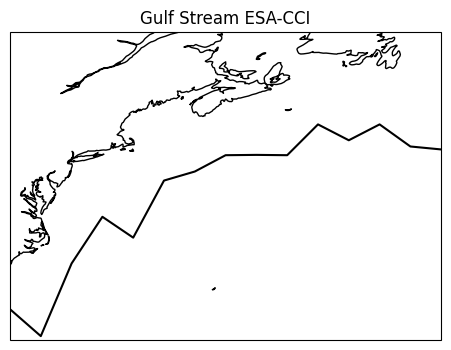

In [22]:
fig,ax = plt.subplots(figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})

#punti = ax.scatter(index_max_value_seas_mean.lon - 360, index_max_value_seas_mean.data, color='black', marker='o',transform=ccrs.PlateCarree())
ax.plot(index_max_value_seas_mean.lon - 360, index_max_value_seas_mean.data, color='black', linestyle='-', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim([lon.min(), lon.max()])
ax.set_ylim([lat.min(), lat.max()])
ax.set_title('Gulf Stream ESA-CCI')

Text(0.5, 1.0, 'GS Cluster 0')

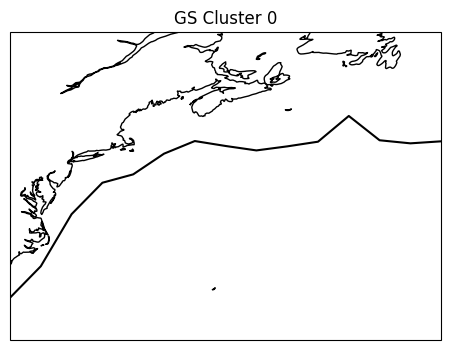

In [23]:
fig,ax = plt.subplots(figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})

#punti = ax.scatter(array_max_mean_seas[0].lon - 360, array_max_mean_seas[0].data, color='black', marker='o',transform=ccrs.PlateCarree())
ax.plot(array_max_mean_seas[0].lon - 360, array_max_mean_seas[0].data, color='black', linestyle='-', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim([lon.min(), lon.max()])
ax.set_ylim([lat.min(), lat.max()])
ax.set_title('GS Cluster 0')

Text(0.5, 0.92, 'SST, gradiente SST, bias medio SST in DJF per ogni cluster')

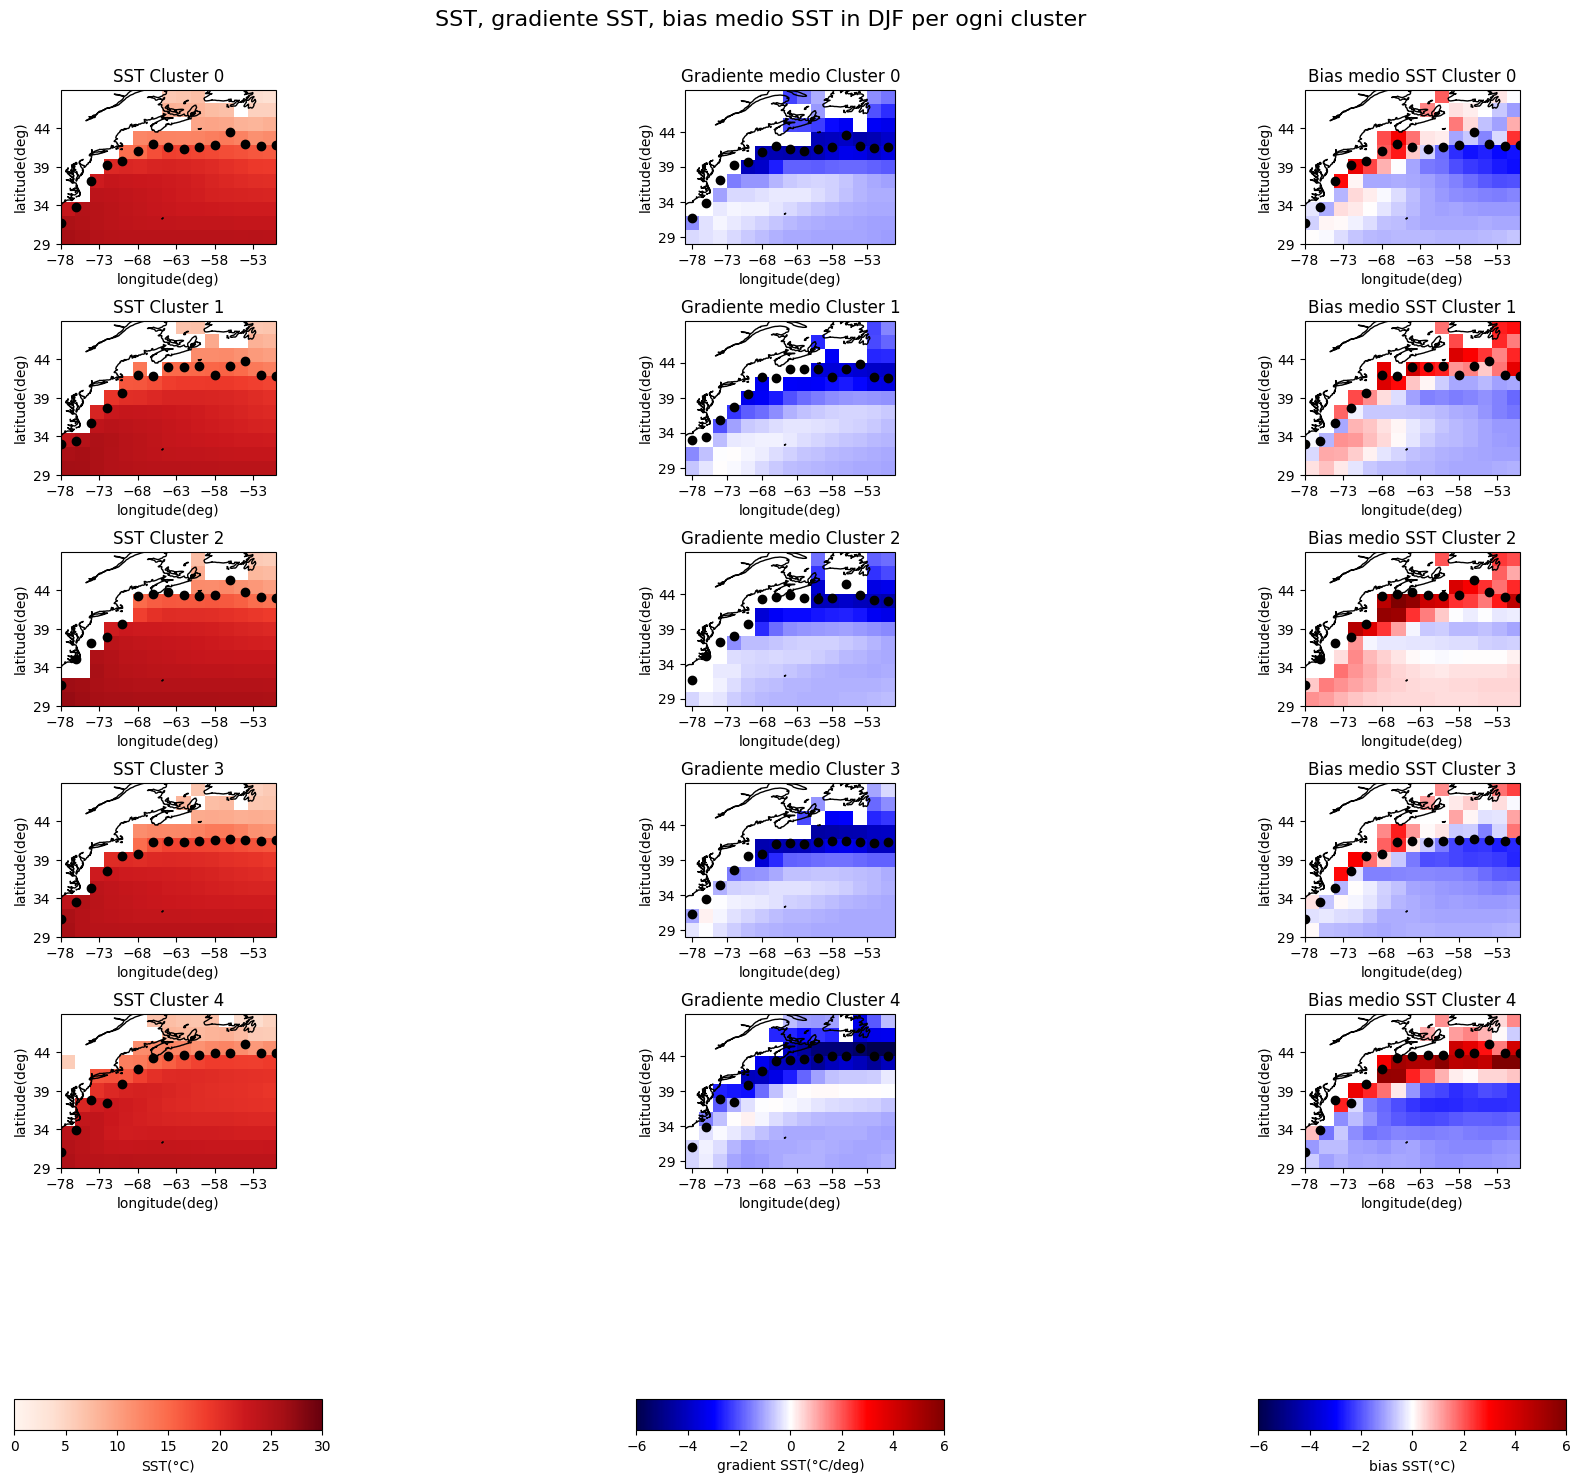

In [24]:
index = 0 #inizializzo l'indice che individua ogni cluster
fig,ax = plt.subplots(nrows=5,ncols=3,figsize=(24,20),subplot_kw={"projection": ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.5, wspace=0.01)  # Aggiungo spazi verticali e orizzontali tra le subplots
for i in range(5): #Ciclo sulle righe
    j = 0 #inziializzo indice per le colonne
    #Plot della prima colonna, cioè di SST
    punti = ax[i,j].scatter(array_max_mean_seas[index].lon - 360, array_max_mean_seas[index].data, color='black', marker='o',transform=ccrs.PlateCarree())
    plot_mod_sst = ax[i,j].imshow(mean_cluster[index,::-1,:],extent=[lon.min(), lon.max(), lat.min(), lat.max()],vmin=0, vmax=30,cmap='Reds',transform=ccrs.PlateCarree())
    ax[i,j].coastlines()
    ax[i,j].set_title(f'SST Cluster {index}')
    #Plot della seconda colonna, cioè del gradiente di SST
    plot_mod_gradient = mean_gradient_seas_mean[index].plot(ax=ax[i,j+1],cmap='seismic',vmin=-6,vmax=6, add_colorbar=False,transform=ccrs.PlateCarree())
    punti = ax[i,j+1].scatter(array_max_mean_seas[index].lon - 360, array_max_mean_seas[index].data, color='black', marker='o',transform=ccrs.PlateCarree())
    ax[i,j+1].coastlines()
    ax[i,j+1].set_title(f'Gradiente medio Cluster {index}')
    #Plot della terza colonna, cioè del bias DJF di SST
    punti = ax[i,j+2].scatter(array_max_mean_seas[index].lon - 360, array_max_mean_seas[index].data, color='black', marker='o',transform=ccrs.PlateCarree())
    plot_mod_bias = ax[i,j+2].imshow(mean_bias[index,::-1,:],extent=[lon.min(), lon.max(), lat.min(), lat.max()],cmap='seismic',vmin=-6,vmax=6,transform=ccrs.PlateCarree())
    ax[i,j+2].coastlines()
    ax[i,j+2].set_title(f'Bias medio SST Cluster {index}')

    j = 0
    for j in range(3):
        ax[i,j].set_xlabel('longitude(deg)')
        ax[i,j].set_ylabel('latitude(deg)') 
        ax[i,j].set_xticks(np.arange(lon.min(), lon.max(), 5))
        ax[i,j].set_yticks(np.arange(lat.min(), lat.max(), 5))

    index = index + 1 #Aggiorno index
fig.colorbar(plot_mod_sst,ax=ax[:,0],orientation='horizontal', shrink=0.5, aspect=10).set_label('SST(°C)')
fig.colorbar(plot_mod_gradient,ax=ax[:,1],orientation='horizontal', shrink=0.5, aspect=10).set_label('gradient SST(°C/deg)')
fig.colorbar(plot_mod_bias,ax=ax[:,2],orientation='horizontal', shrink=0.5, aspect=10).set_label('bias SST(°C)')
fig.suptitle('SST, gradiente SST, bias medio SST in DJF per ogni cluster', fontsize=16, y=0.92)

Plot della gulf stream di tutti i cluster, della gulf stream di multi model mean, della gulf stream di ESA-CCI

Text(0.5, 0.98, 'Gulf Stream')

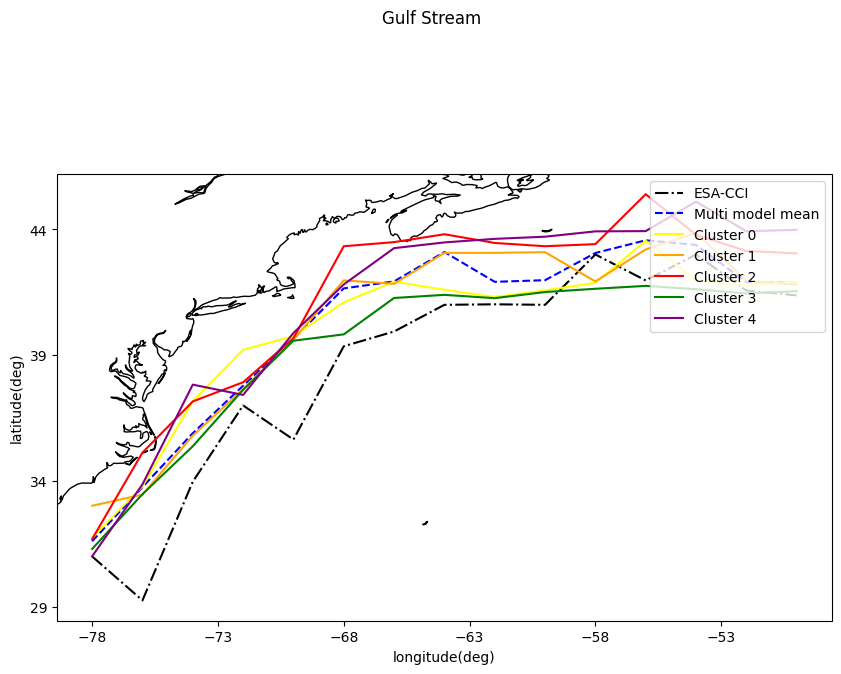

In [29]:
color_list = ['black','blue','yellow','orange','red','green','purple'] #lista di colori perché voglio colori tutti diversi per le diverse Gulf Stream
fig, ax = plt.subplots(figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
ax.plot(index_max_value_seas_mean.lon - 360, index_max_value_seas_mean.data, color=color_list[0], linestyle='-.', transform=ccrs.PlateCarree(),label='ESA-CCI')
ax.plot(array_max_mean_seas_all_models.lon - 360, array_max_mean_seas_all_models.data, color=color_list[1], linestyle='--', transform=ccrs.PlateCarree(),label='Multi model mean')
for index in range(5):
    ax.plot(array_max_mean_seas[index].lon - 360, array_max_mean_seas[index].data, color=color_list[index+2], linestyle='-', transform=ccrs.PlateCarree(),label=f'Cluster {index}')
ax.coastlines()
ax.legend(loc='upper right')
ax.set_xlabel('longitude(deg)')
ax.set_ylabel('latitude(deg)') 
ax.set_xticks(np.arange(lon.min(), lon.max(), 5))
ax.set_yticks(np.arange(lat.min(), lat.max(), 5))
fig.suptitle('Gulf Stream')